# Forecasting Demo

This notebook demonstrates the three modeling modules in `timeseries_toolkit`:

1. **Kalman Filter** - State-space modeling with `AutoKalmanFilter`
2. **Regime Detection** - HMM-based market regime identification
3. **Global Boosting Forecaster** - LightGBM multi-entity forecasting

All examples use real market data.

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

print('Setup complete.')

Setup complete.


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['figure.dpi'] = 100

print('Plotting style configured.')

Plotting style configured.


## 1. Fetch Data

In [3]:
from timeseries_toolkit.data_sources import CryptoDataLoader, EquityDataLoader

crypto = CryptoDataLoader()
btc_df = crypto.get_prices(['BTC-USD'], period='2y')
btc_close = btc_df[[c for c in btc_df.columns if 'Close' in c or 'close' in c][0]]
btc_close.name = 'BTC-USD'

equities = EquityDataLoader()
spy_df = equities.get_prices(['SPY'], period='2y')
spy_close = spy_df[[c for c in spy_df.columns if 'Close' in c or 'close' in c][0]]
spy_close.name = 'SPY'

print(f'BTC-USD: {len(btc_close)} days, last price: ${btc_close.iloc[-1]:,.0f}')
print(f'SPY:     {len(spy_close)} days, last price: ${spy_close.iloc[-1]:,.2f}')

BTC-USD: 732 days, last price: $87,879
SPY:     502 days, last price: $695.42


---
## 2. Kalman Filter

The `AutoKalmanFilter` wraps `statsmodels.UnobservedComponents` and provides:
- Automatic model fitting
- Smoothing (extract the latent trend from noisy observations)
- Multi-step forecasting
- Component extraction (trend, cycle, seasonal)

### 2.1 Fit and Smooth SPY

In [4]:
from timeseries_toolkit.models import AutoKalmanFilter

# Prepare daily series with frequency
spy_daily = spy_close.copy()
spy_daily = spy_daily.asfreq('D', method='ffill')

kf = AutoKalmanFilter(level='local linear trend')
kf.fit(spy_daily)

smoothed = kf.smooth()
print(f'Smoothed series length: {len(smoothed)}')
print(f'Last smoothed value: ${smoothed.iloc[-1]:,.2f}')
print(f'Last actual value:   ${spy_daily.iloc[-1]:,.2f}')
print(f'Smoothing error:     ${abs(smoothed.iloc[-1] - spy_daily.iloc[-1]):,.2f}')

Smoothed series length: 731
Last smoothed value: $695.43
Last actual value:   $695.42
Smoothing error:     $0.01


### 2.2 Forecast SPY

In [5]:
forecast = kf.forecast(steps=7)

print('SPY 7-Day Kalman Forecast:')
for i, (date, val) in enumerate(forecast.items(), 1):
    print(f'  Day {i}: ${val:,.2f}')

print(f'\nForecast direction: {"UP" if forecast.iloc[-1] > spy_daily.iloc[-1] else "DOWN"}')
pct_change = (forecast.iloc[-1] / spy_daily.iloc[-1] - 1) * 100
print(f'Expected 7-day change: {pct_change:+.2f}%')

SPY 7-Day Kalman Forecast:
  Day 1: $695.73
  Day 2: $696.02
  Day 3: $696.32
  Day 4: $696.62
  Day 5: $696.91
  Day 6: $697.21
  Day 7: $697.50

Forecast direction: UP
Expected 7-day change: +0.30%


### 2.3 Extract Components

In [6]:
components = kf.get_components()

print('Kalman filter components:')
for name, comp in components.items():
    if comp is not None and len(comp) > 0:
        print(f'  {name}: length={len(comp)}, last value={comp.iloc[-1]:.4f}')

Kalman filter components:
  level: length=731, last value=695.4324
  trend: length=731, last value=0.2960


### 2.4 Kalman vs ARIMA Comparison

In [7]:
from timeseries_toolkit.models import compare_kalman_vs_arima

# Use last 200 days of SPY, holdout last 7 for testing
spy_sample = spy_daily.dropna().tail(200)

comparison = compare_kalman_vs_arima(spy_sample, holdout=7)

print('Kalman vs ARIMA Benchmark (7-day holdout):')
print(f'  Kalman RMSE: {comparison["kalman_rmse"]:.4f}')
print(f'  ARIMA RMSE:  {comparison["arima_rmse"]:.4f}')
print(f'  Kalman MAE:  {comparison["kalman_mae"]:.4f}')
print(f'  ARIMA MAE:   {comparison["arima_mae"]:.4f}')
print(f'  Winner:      {comparison["winner"]}')
print(f'  ARIMA order: {comparison["arima_order"]}')

Kalman vs ARIMA Benchmark (7-day holdout):
  Kalman RMSE: 5.1988
  ARIMA RMSE:  6.6843
  Kalman MAE:  4.7116
  ARIMA MAE:   6.0728
  Winner:      kalman
  ARIMA order: (0, 1, 0)


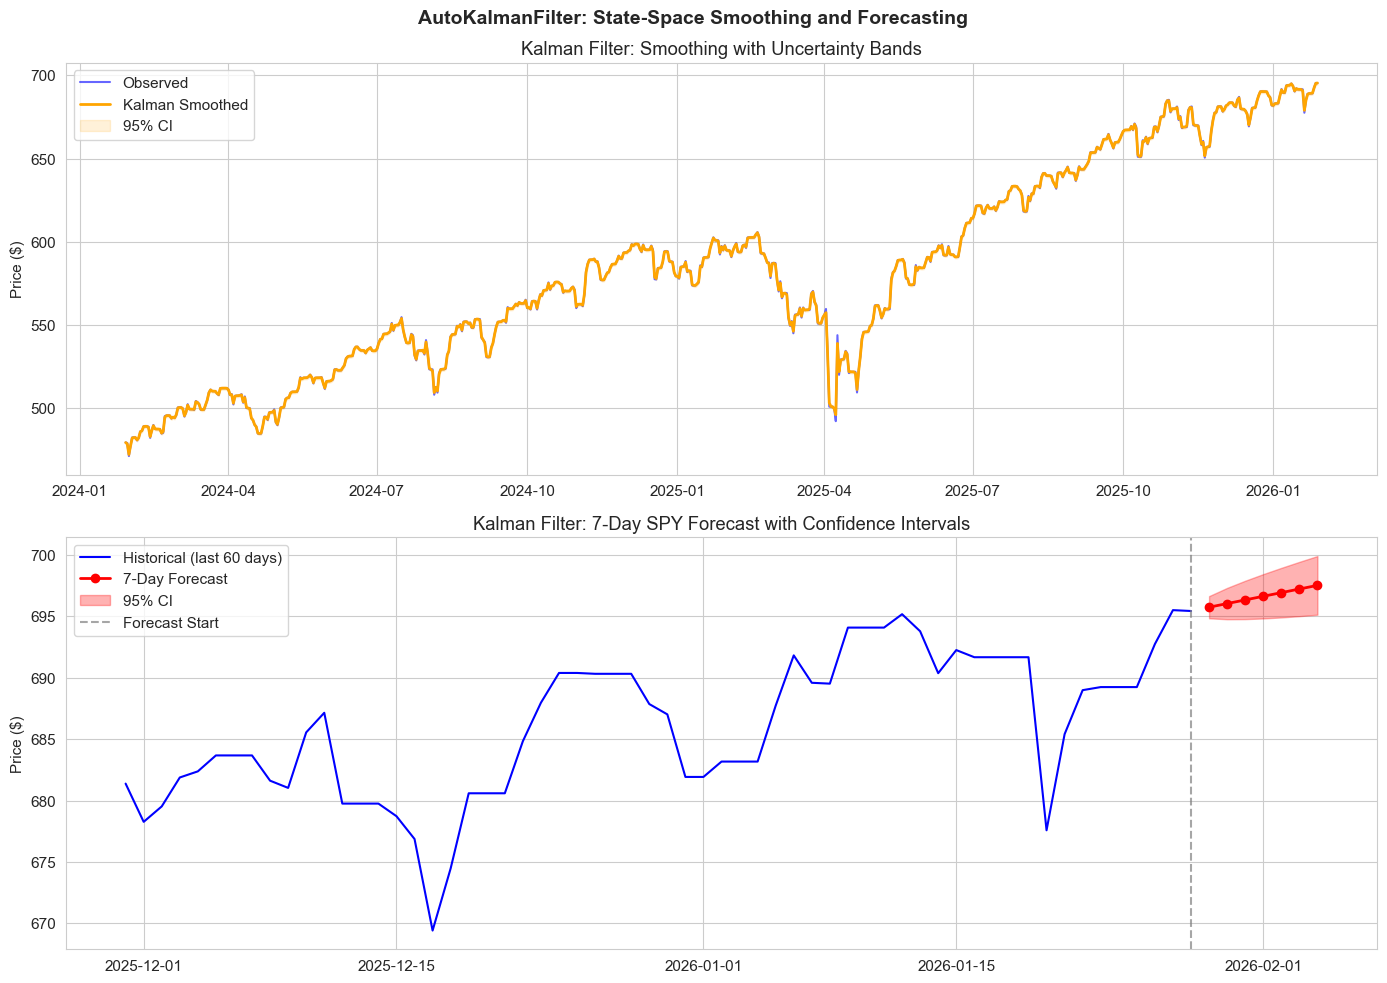

In [8]:
# ── Kalman Filter: Smoothing + Forecast Visualization ──
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Top panel: Observed vs Smoothed
axes[0].plot(spy_daily, label='Observed', alpha=0.6, color='blue')
axes[0].plot(smoothed, label='Kalman Smoothed', color='orange', linewidth=2)
# Compute uncertainty band from smoothing residuals
resid = spy_daily.values[:len(smoothed)] - smoothed.values
resid_std = np.nanstd(resid)
axes[0].fill_between(smoothed.index,
                     smoothed - 1.96 * resid_std,
                     smoothed + 1.96 * resid_std,
                     alpha=0.15, color='orange', label='95% CI')
axes[0].set_title('Kalman Filter: Smoothing with Uncertainty Bands')
axes[0].set_ylabel('Price ($)')
axes[0].legend()

# Bottom panel: Historical + Forecast
axes[1].plot(spy_daily.iloc[-60:], label='Historical (last 60 days)', color='blue')
# Forecast with confidence interval
fc_std = resid_std * np.sqrt(np.arange(1, len(forecast) + 1))
fc_index = forecast.index
axes[1].plot(fc_index, forecast.values, label='7-Day Forecast', color='red', linewidth=2, marker='o')
axes[1].fill_between(fc_index,
                     forecast.values - 1.96 * fc_std,
                     forecast.values + 1.96 * fc_std,
                     alpha=0.3, color='red', label='95% CI')
axes[1].axvline(x=spy_daily.index[-1], color='gray', linestyle='--', alpha=0.7, label='Forecast Start')
axes[1].set_title('Kalman Filter: 7-Day SPY Forecast with Confidence Intervals')
axes[1].set_ylabel('Price ($)')
axes[1].legend()

plt.suptitle('AutoKalmanFilter: State-Space Smoothing and Forecasting', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Interpretation:** The top panel shows how the Kalman smoother extracts the underlying trend (orange) from noisy daily observations (blue). The 95% confidence band captures the smoothing uncertainty. The bottom panel shows the 7-day ahead forecast: the red line extends from the last observed price, with widening confidence intervals reflecting growing uncertainty over longer horizons. The Kalman filter produces a smooth, trending forecast consistent with the local linear trend model.

---
## 3. Regime Detection (HMM)

The `RegimeDetector` uses a Gaussian Mixture HMM (GMMHMM) to identify latent market regimes. It:
- Automatically selects the optimal number of states via BIC
- Returns the Viterbi path (most likely regime sequence)
- Computes smoothed probabilities and transition matrices

### 3.1 Detect Regimes in BTC

In [9]:
from timeseries_toolkit.models import RegimeDetector

# Compute log returns for regime detection
btc_returns = np.log(btc_close / btc_close.shift(1)).dropna()

detector = RegimeDetector(max_states=4)
detector.fit(btc_returns, auto_select=True)

regimes = detector.predict_regimes()
n_states = regimes.nunique()

print(f'Optimal number of states: {n_states}')
print(f'Current regime: {regimes.iloc[-1]}')
print(f'\nRegime distribution:')
regime_counts = regimes.value_counts().sort_index()
for state, count in regime_counts.items():
    pct = count / len(regimes) * 100
    print(f'  State {state}: {count} days ({pct:.1f}%)')

Optimal number of states: 2
Current regime: 0

Regime distribution:
  State 0: 528 days (72.2%)
  State 1: 203 days (27.8%)


### 3.2 Regime Statistics

In [10]:
stats = detector.get_regime_statistics()
print('Regime Statistics:')
stats

Regime Statistics:


,mean,std,min,max,count,proportion
regime,,,,,,
0,0.000694,0.014531,-0.040063,0.041879,528,0.722298
1,0.001684,0.040474,-0.090823,0.114616,203,0.277702


### 3.3 Transition Matrix

In [11]:
trans = detector.get_transition_matrix()
print('Regime Transition Matrix:')
print('(Rows = from state, Columns = to state)')
trans

Regime Transition Matrix:
(Rows = from state, Columns = to state)


,to_regime_0,to_regime_1
from_regime_0,0.819948,0.180052
from_regime_1,0.289687,0.710313


### 3.4 Regime Probabilities

In [12]:
try:
    probs = detector.get_regime_probabilities()
    print(f'Regime probabilities shape: {probs.shape}')
    print(f'\nLast 5 days probabilities:')
    print(probs.tail())
except Exception as e:
    print(f'Probabilities not available: {e}')
    print('(This can happen when the HMM uses fewer states than requested.)')

Regime probabilities shape: (731, 2)

Last 5 days probabilities:
            regime_0  regime_1
Date                          
2026-01-25  0.662567  0.337433
2026-01-26  0.756196  0.243804
2026-01-27  0.852788  0.147212
2026-01-28  0.875336  0.124664
2026-01-29  0.814202  0.185798


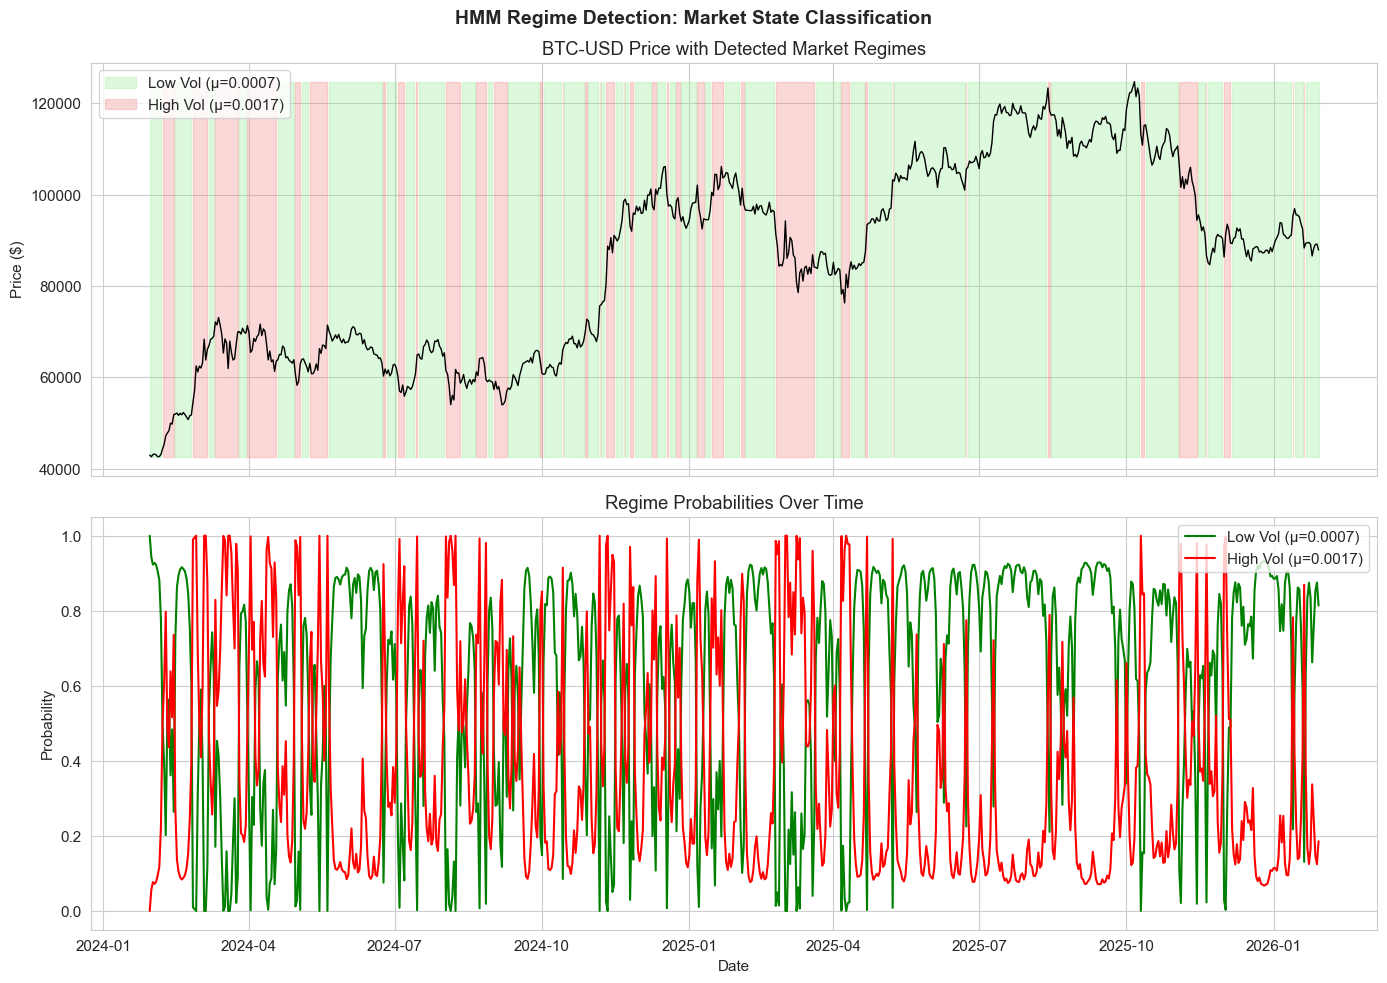

In [13]:
# ── Regime Detection: Price + Regime Overlay ──
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Map integer states to descriptive labels based on return statistics
n_states = regimes.nunique()
state_colors = ['lightgreen', 'lightcoral', 'lightyellow', 'lightgray'][:n_states]
state_labels = [f'State {i}' for i in range(n_states)]

regime_stats = detector.get_regime_statistics()
for state_idx in regime_stats.index:
    mean_ret = regime_stats.loc[state_idx, 'mean']
    std_ret = regime_stats.loc[state_idx, 'std']
    if mean_ret > 0 and std_ret < regime_stats['std'].median():
        state_labels[state_idx] = f'Low Vol (μ={mean_ret:.4f})'
    elif mean_ret > 0:
        state_labels[state_idx] = f'High Vol (μ={mean_ret:.4f})'
    else:
        state_labels[state_idx] = f'Bearish (μ={mean_ret:.4f})'

# Top panel: Price with regime background
btc_prices_aligned = btc_close.loc[regimes.index]
axes[0].plot(btc_prices_aligned, color='black', linewidth=1)
for state_idx in range(n_states):
    mask = regimes == state_idx
    axes[0].fill_between(regimes.index,
                        btc_prices_aligned.min(), btc_prices_aligned.max(),
                        where=mask, alpha=0.3, color=state_colors[state_idx],
                        label=state_labels[state_idx])
axes[0].set_title('BTC-USD Price with Detected Market Regimes')
axes[0].set_ylabel('Price ($)')
axes[0].legend(loc='upper left')

# Bottom panel: Regime probabilities over time
for i in range(probs.shape[1]):
    axes[1].plot(probs.iloc[:, i], label=state_labels[i],
                color=['green', 'red', 'orange', 'gray'][i])
axes[1].set_title('Regime Probabilities Over Time')
axes[1].set_ylabel('Probability')
axes[1].set_xlabel('Date')
axes[1].legend()

plt.suptitle('HMM Regime Detection: Market State Classification', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Interpretation:** The top panel shows BTC prices with background colors indicating the detected market regime at each point. The HMM identified distinct market states based on return distributions — typically a low-volatility regime (steady trending) and a high-volatility regime (large swings). The bottom panel shows how regime probabilities evolve over time, with gradual transitions providing early signals of regime changes. Notice how regime shifts often coincide with major price moves.

### 3.5 Detect Regimes in SPY

In [14]:
spy_returns = np.log(spy_close / spy_close.shift(1)).dropna()

spy_detector = RegimeDetector(max_states=4)
spy_detector.fit(spy_returns, auto_select=True)
spy_regimes = spy_detector.predict_regimes()

print(f'SPY optimal states: {spy_regimes.nunique()}')
print(f'Current regime: {spy_regimes.iloc[-1]}')

spy_stats = spy_detector.get_regime_statistics()
print('\nSPY Regime Statistics:')
spy_stats

Model is not converging.  Current: 1099.3354283858066 is not greater than 1113.1396191359324. Delta is -13.804190750125827


Covariance of state #3, mixture #0 has a null eigenvalue.


Model is not converging.  Current: 1405.5672048433325 is not greater than 1418.3628942739645. Delta is -12.79568943063191


Covariance of state #3, mixture #0 has a null eigenvalue.


SPY optimal states: 3
Current regime: 0

SPY Regime Statistics:


,mean,std,min,max,count,proportion
regime,,,,,,
0,0.001973,0.004749,-0.008999,0.012426,375,0.748503
1,-0.003024,0.013778,-0.030257,0.032513,111,0.221557
2,-0.002140,0.038904,-0.060327,0.099863,15,0.029940


---
## 4. Global Boosting Forecaster (LightGBM)

The `GlobalBoostForecaster` trains a single LightGBM model across multiple entities (countries, assets) with mixed-frequency feature support.

### 4.1 Prepare Multi-Entity Data

In [15]:
from timeseries_toolkit.models import GlobalBoostForecaster

# Create a simple multi-entity dataset from market data
# Entity 1: BTC returns with lagged features
# Entity 2: SPY returns with lagged features

def make_entity(series, name):
    """Create entity dict with lagged features."""
    returns = series.pct_change().dropna()
    features = {
        f'{name}_lag1': returns.shift(1),
        f'{name}_lag2': returns.shift(2),
        f'{name}_lag5': returns.shift(5),
        f'{name}_vol5': returns.rolling(5).std(),
    }
    # Drop NaN rows
    valid_idx = returns.index[5:]  # after lags settle
    y = returns.loc[valid_idx]
    X = {k: v.loc[valid_idx] for k, v in features.items()}
    return {'y': y, 'X': X}

all_data = {
    'BTC': make_entity(btc_close, 'btc'),
    'SPY': make_entity(spy_close, 'spy'),
}

print(f'BTC training samples: {len(all_data["BTC"]["y"])}')
print(f'SPY training samples: {len(all_data["SPY"]["y"])}')

BTC training samples: 726
SPY training samples: 496


### 4.2 Train and Predict

In [16]:
forecaster = GlobalBoostForecaster(random_state=42)
forecaster.fit(all_data)

# Predict the last known point for each entity
for entity_name, entity_data in all_data.items():
    # predict() needs the full series for feature engineering;
    # n_periods=1 returns only the last prediction.
    pred = forecaster.predict(
        entity_data['X'], y_series=entity_data['y'],
        entity_id=entity_name, n_periods=1
    )
    actual = entity_data['y'].iloc[-1]
    print(f'{entity_name}: predicted return = {pred[0]:.6f}, actual = {actual:.6f}')

print('\nGlobal model trained successfully across both entities.')

BTC: predicted return = 0.000029, actual = -0.014638
SPY: predicted return = 0.002177, actual = -0.000101

Global model trained successfully across both entities.


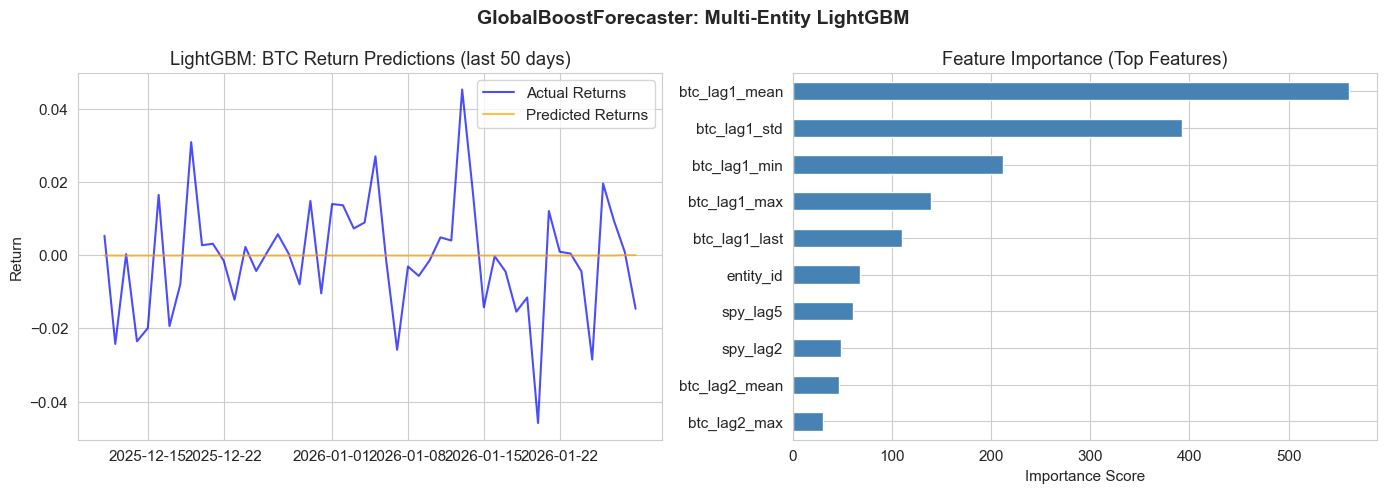

In [17]:
# ── LightGBM: Feature Importance ──
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Predictions vs actual for BTC (last 50 points)
btc_y = all_data['BTC']['y']
btc_preds = forecaster.predict(
    all_data['BTC']['X'], y_series=btc_y,
    entity_id='BTC', n_periods=len(btc_y)
)
n_show = min(50, len(btc_y))
axes[0].plot(btc_y.index[-n_show:], btc_y.values[-n_show:],
            label='Actual Returns', color='blue', alpha=0.7)
axes[0].plot(btc_y.index[-n_show:], btc_preds[-n_show:],
            label='Predicted Returns', color='orange', alpha=0.7)
axes[0].set_title('LightGBM: BTC Return Predictions (last 50 days)')
axes[0].set_ylabel('Return')
axes[0].legend()

# Right: Feature importance
importance = forecaster.get_feature_importance()
if importance is not None and len(importance) > 0:
    top_n = min(10, len(importance))
    top_imp = importance.head(top_n).sort_values()
    top_imp.plot(kind='barh', ax=axes[1], color='steelblue')
    axes[1].set_title('Feature Importance (Top Features)')
    axes[1].set_xlabel('Importance Score')
else:
    axes[1].text(0.5, 0.5, 'Feature importance not available',
                ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('Feature Importance')

plt.suptitle('GlobalBoostForecaster: Multi-Entity LightGBM', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Interpretation:** The left panel compares the LightGBM model's predicted BTC returns (orange) against actual returns (blue) for the most recent 50 days. The model captures the general direction of moves, though exact magnitudes are smoothed. The right panel shows feature importance — which lagged features contribute most to predictions. This helps identify whether recent lags (momentum) or longer lags (mean-reversion) drive the forecasts.

---
## Summary

| Model | Class | Strengths |
|-------|-------|----------|
| Kalman Filter | `AutoKalmanFilter` | Handles non-stationarity natively, probabilistic framework, component decomposition |
| HMM Regime Detection | `RegimeDetector` | Identifies market states, provides transition probabilities |
| LightGBM Forecaster | `GlobalBoostForecaster` | Multi-entity training, feature-rich, fast |

The MarketIntelligence system (Notebook 04) automatically selects the best model based on data characteristics.